In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import  json
import requests
import pandas as pd
import numpy as np
import os,shutil

from nltk import word_tokenize
from gensim.models import word2vec

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
import string

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# the gensim library may need to be installed depensing on how colab is running nlp packages

In [ ]:
# pip install --upgrade gensim

# colab mappings

## you want to make sure that is is your custom set up of where you located your files and have your directories set up. but if you mimick the structure I have you should be able to run the code with out interuption.

In [ ]:
# checking where we are in colab. 
os.chdir('drive/MyDrive/Legal-Document-Identifier-')

## code to break out law type in map

In [ ]:
f = open("Map.txt", "r")
content = f.read()

In [ ]:
lawcat=content.splitlines()
f.close()

In [ ]:
catagories=[]
for itemset in lawcat:
    meepset=itemset.partition('->')
    catagories.append(meepset)

In [ ]:
data=pd.DataFrame(columns=['case_text','case_type'])

In [ ]:
main_directory=os.getcwd()

pathToText='raw_cases/raw_cases'

In [ ]:
path=os.path.join(main_directory,pathToText)

In [ ]:
masterpath=os.listdir(path)

## next line of code takes some time to run,5> minutes

In [ ]:
counterfordocuments=1

for folder in masterpath[:-1]:
    subfile=os.listdir(os.path.join(path,folder))
    for rawtext in subfile:
        with open(os.path.join(path,folder)+'/' +rawtext,'r',encoding='utf-8') as f:
            content=f.read()
            vardict=pd.DataFrame({'case_text':content,'case_type':folder},index=[counterfordocuments])
            data=data.append(vardict)
            counterfordocuments+= 1

# remap numbers to text

In [ ]:
law_cat_map={}
for item in catagories:
    law_cat_map[item[0].strip()]=item[2]

In [ ]:
law_type_df=data.replace({'case_type':law_cat_map})


In [ ]:
law_type_df.groupby(['case_type']).count().sort_values(by=['case_text'],ascending=False)

case_text
case_type                           
 Immigration Law                2332
 Insurance Law                  1569
 Habeas Corpus                  1511
 Health Law                     1455
 Family Law                     1203
...                              ...
 Tax-exempt Organizations         74
 Judges &amp; Judiciary           65
 Legal Malpractice                61
 M&amp;A                          52
 Trade Dress                      22

[75 rows x 1 columns]

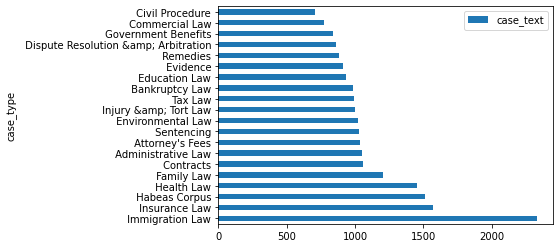

In [ ]:
law_type_df.groupby(['case_type']).count().sort_values(by=['case_text'],ascending=False)[0:20].plot(kind='barh')

In [ ]:
forcasename=law_type_df.groupby(['case_type']).count().sort_values(by=['case_text'],ascending=False)[0:20]

In [ ]:
caselist20=list(forcasename.index)

In [ ]:
data_frame20=pd.DataFrame(columns=['case_text','case_type'])
for casetype in caselist20:
    tempval=law_type_df[law_type_df.case_type==casetype]
    data_frame20=data_frame20.append(tempval)




# check point

In [ ]:
data_frame20.case_type.value_counts()

 Immigration Law                         2332
 Insurance Law                           1569
 Habeas Corpus                           1511
 Health Law                              1455
 Family Law                              1203
 Contracts                               1059
 Administrative Law                      1053
 Attorney's Fees                         1034
 Sentencing                              1032
 Environmental Law                       1024
 Injury &amp; Tort Law                   1000
 Tax Law                                  991
 Bankruptcy Law                           988
 Education Law                            936
 Evidence                                 912
 Remedies                                 883
 Dispute Resolution &amp; Arbitration     864
 Government Benefits                      836
 Commercial Law                           771
 Civil Procedure                          709
Name: case_type, dtype: int64

In [ ]:
# use this for the tfidf tokenizer
pip install lexnlp

In [ ]:
import lexnlp.nlp.en.tokens
from sklearn.feature_extraction.text import TfidfVectorizer

## function for the different forms and iterative modeling in one place.  most of the changes were to get relevant terms, ngrams etc.  to see if it affected model performance. 

In [ ]:
def clean_by_case_data(relevancy,dataset_infunc):
    
    textdata=dataset_infunc['case_text']
    target = dataset_infunc['case_type']
    processed_data= [lexnlp.nlp.en.tokens.get_token_list(d, lowercase=True, stopword=True) for d in textdata.tolist()]
    
    sw_list = stopwords.words('english')
    sw_list += list(string.punctuation)
    sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©','-', '–', '—','()','( )','(']
    sw_set = set(sw_list)
    
    lemmatizer = WordNetLemmatizer() 

    lemmatized_output = []

    for listy in processed_data:
        lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
        lemmatized_output.append(lemmed)
        
    into_vectorx = lemmatized_output
    
    if relevancy=='ngram':
    
        relevantTrain=[]
       
        tfidf = TfidfVectorizer(stop_words=sw_set,ngram_range=(0,2),min_df=.1)
    
        tfidf_data_train_lem = tfidf.fit_transform(into_vectorx)
        
        Xtrain_relevant=pd.DataFrame(tfidf_data_train_lem.todense(),columns = tfidf.get_feature_names())
        

                
        return Xtrain_relevant,target
    
    elif relevancy=='NNdata':
       
        tfidf = TfidfVectorizer(stop_words=sw_set,ngram_range=(0,2),min_df=.1)
    
        tfidf_data_train_lem = tfidf.fit_transform(into_vectorx)
        
        Xtrain_relevant=pd.DataFrame(tfidf_data_train_lem.todense(),columns = tfidf.get_feature_names())
        
                
        return Xtrain_relevant,target
    
    elif relevancy=='ngram3':
    
        relevantTrain=[]
       
        tfidf = TfidfVectorizer(stop_words=sw_set,ngram_range=(0,3),min_df=.1)
    
        tfidf_data_train_lem = tfidf.fit_transform(into_vectorx)
        
        Xtrain_relevant=pd.DataFrame(tfidf_data_train_lem.todense(),columns = tfidf.get_feature_names())
        
                
        return Xtrain_relevant,target
    
    elif relevancy== True:
        
        relevantTrain=[]
       
        tfidf = TfidfVectorizer(stop_words=sw_set)
    
        tfidf_data_train_lem = tfidf.fit_transform(into_vectorx)
        
        Xtrain_relevant=pd.DataFrame(tfidf_data_train_lem.todense(),columns = tfidf.get_feature_names())
        
        for word in Xtrain_relevant.columns:
            if Xtrain_relevant[word].mean() > 0.0001:
                relevantTrain.append(Xtrain_relevant[word])
        

        
        
        return relevantTrain,target
#         return X_train_lem, X_test_lem, y_train_lem, y_test_lem,tfidf,relevantTrain,relevantTest,relevant_frame;
        
    else:
    
        X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(into_vectorx, target, test_size=0.20, random_state=1)
    
        tfidf = TfidfVectorizer(stop_words=sw_set)
    
        tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
        tfidf_data_test_lem = tfidf.transform(X_test_lem)

    
        return X_train_lem, X_test_lem, y_train_lem, y_test_lem,tfidf,tfidf_data_train_lem,tfidf_data_test_lem

run model fucntion to get clean output of results for train and test sets

In [ ]:
def run_model(model, X_train, y_train, X_test, y_test):
#     print('List of models to choose from\n DTC : DecisionTreeClassifier\n')
    decis = model
    decis.fit(X_train, y_train)
    
    y_hat_train = decis.predict(X_train)
    y_hat_test = decis.predict(X_test)
    
    print(classification_report(y_train, y_hat_train))
    print(classification_report(y_test, y_hat_test))
    
    
  
    return  model# return the model object!!

## lets start modeling 

In [ ]:
Xtrain,Xtest,Ytrain,Ytest,origtfidfmodelvec,Xtrain_trans,Xtest_Trans=clean_by_case_data(False,data_frame20)

In [ ]:
#not that a few of the models for obvious reason per the dataset took to long to run so we are commenting them out

knn_base=KNeighborsClassifier()
tree_base=tree.DecisionTreeClassifier()
random_base=RandomForestClassifier(n_estimators=100, max_depth= 20)
log_base=LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
xboost_base=XGBClassifier()
dt_base = DecisionTreeClassifier()
bagged_base=BaggingClassifier()
mnb_base = MultinomialNB()
# gb_base = GradientBoostingClassifier()
# svm_base=svm.SVC(decision_function_shape='ovo')
# ada_base = AdaBoostClassifier()


In [ ]:
run_model(log_base,Xtrain_trans,Ytrain,Xtest_Trans,Ytest)

                                       precision    recall  f1-score   support

                   Administrative Law       1.00      1.00      1.00       856
                      Attorney's Fees       1.00      1.00      1.00       805
                       Bankruptcy Law       1.00      1.00      1.00       805
                      Civil Procedure       1.00      1.00      1.00       577
                       Commercial Law       1.00      1.00      1.00       612
                            Contracts       1.00      1.00      1.00       838
 Dispute Resolution &amp; Arbitration       1.00      1.00      1.00       696
                        Education Law       1.00      1.00      1.00       766
                    Environmental Law       1.00      1.00      1.00       846
                             Evidence       1.00      1.00      1.00       741
                           Family Law       1.00      1.00      1.00       979
                  Government Benefits       1.00   

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [ ]:
# run_model(svm_base,Xtrain_trans,Ytrain,Xtest_Trans,Ytest)

In [ ]:
run_model(dt_base,Xtrain_trans,Ytrain,Xtest_Trans,Ytest)

                                       precision    recall  f1-score   support

                   Administrative Law       1.00      1.00      1.00       856
                      Attorney's Fees       1.00      1.00      1.00       805
                       Bankruptcy Law       1.00      1.00      1.00       805
                      Civil Procedure       1.00      1.00      1.00       577
                       Commercial Law       1.00      1.00      1.00       612
                            Contracts       1.00      1.00      1.00       838
 Dispute Resolution &amp; Arbitration       1.00      1.00      1.00       696
                        Education Law       1.00      1.00      1.00       766
                    Environmental Law       1.00      1.00      1.00       846
                             Evidence       1.00      1.00      1.00       741
                           Family Law       1.00      1.00      1.00       979
                  Government Benefits       1.00   

DecisionTreeClassifier()

In [ ]:
run_model(bagged_base,Xtrain_trans,Ytrain,Xtest_Trans,Ytest)

                                       precision    recall  f1-score   support

                   Administrative Law       0.99      0.97      0.98       856
                      Attorney's Fees       0.97      0.98      0.98       805
                       Bankruptcy Law       0.97      1.00      0.99       805
                      Civil Procedure       0.99      0.98      0.99       577
                       Commercial Law       0.99      0.98      0.98       612
                            Contracts       0.99      0.98      0.99       838
 Dispute Resolution &amp; Arbitration       0.99      0.99      0.99       696
                        Education Law       0.98      1.00      0.99       766
                    Environmental Law       0.98      0.99      0.99       846
                             Evidence       0.99      0.99      0.99       741
                           Family Law       0.99      0.99      0.99       979
                  Government Benefits       0.99   

BaggingClassifier()

In [ ]:
run_model(mnb_base,Xtrain_trans,Ytrain,Xtest_Trans,Ytest)

C:\Users\amird\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                       precision    recall  f1-score   support

                   Administrative Law       1.00      0.02      0.03       856
                      Attorney's Fees       0.85      0.46      0.60       805
                       Bankruptcy Law       0.80      0.79      0.80       805
                      Civil Procedure       0.00      0.00      0.00       577
                       Commercial Law       1.00      0.01      0.02       612
                            Contracts       0.94      0.08      0.15       838
 Dispute Resolution &amp; Arbitration       0.80      0.63      0.70       696
                        Education Law       0.88      0.57      0.69       766
                    Environmental Law       0.83      0.83      0.83       846
                             Evidence       0.98      0.13      0.24       741
                           Family Law       0.90      0.82      0.86       979
                  Government Benefits       0.98   

MultinomialNB()

In [ ]:
run_model(ada_base,Xtrain_trans,Ytrain,Xtest_Trans,Ytest)

C:\Users\amird\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                       precision    recall  f1-score   support

                   Administrative Law       0.16      0.16      0.16       856
                      Attorney's Fees       0.28      0.01      0.02       805
                       Bankruptcy Law       0.71      0.94      0.81       805
                      Civil Procedure       0.11      0.02      0.03       577
                       Commercial Law       0.17      0.03      0.05       612
                            Contracts       0.13      0.02      0.03       838
 Dispute Resolution &amp; Arbitration       0.60      0.89      0.71       696
                        Education Law       0.78      0.61      0.69       766
                    Environmental Law       0.68      0.75      0.71       846
                             Evidence       0.32      0.42      0.36       741
                           Family Law       0.74      0.77      0.75       979
                  Government Benefits       0.00   

AdaBoostClassifier()

In [ ]:
run_model(xboost_base,Xtrain_trans,Ytrain,Xtest_Trans,Ytest)

                                       precision    recall  f1-score   support

                   Administrative Law       1.00      1.00      1.00       856
                      Attorney's Fees       1.00      1.00      1.00       805
                       Bankruptcy Law       1.00      1.00      1.00       805
                      Civil Procedure       1.00      1.00      1.00       577
                       Commercial Law       1.00      1.00      1.00       612
                            Contracts       1.00      1.00      1.00       838
 Dispute Resolution &amp; Arbitration       1.00      1.00      1.00       696
                        Education Law       1.00      1.00      1.00       766
                    Environmental Law       1.00      1.00      1.00       846
                             Evidence       1.00      1.00      1.00       741
                           Family Law       1.00      1.00      1.00       979
                  Government Benefits       1.00   

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
run_model(random_base,Xtrain_trans,Ytrain,Xtest_Trans,Ytest)

                                       precision    recall  f1-score   support

                   Administrative Law       1.00      0.71      0.83       856
                      Attorney's Fees       0.98      0.98      0.98       805
                       Bankruptcy Law       0.92      1.00      0.95       805
                      Civil Procedure       1.00      0.87      0.93       577
                       Commercial Law       1.00      0.89      0.94       612
                            Contracts       0.96      0.91      0.93       838
 Dispute Resolution &amp; Arbitration       0.98      0.99      0.98       696
                        Education Law       0.99      0.99      0.99       766
                    Environmental Law       0.99      0.99      0.99       846
                             Evidence       1.00      0.96      0.98       741
                           Family Law       1.00      0.98      0.99       979
                  Government Benefits       0.99   

RandomForestClassifier(max_depth=20)

In [ ]:
run_model(tree_base,Xtrain_trans,Ytrain,Xtest_Trans,Ytest)

                                       precision    recall  f1-score   support

                   Administrative Law       1.00      1.00      1.00       856
                      Attorney's Fees       1.00      1.00      1.00       805
                       Bankruptcy Law       1.00      1.00      1.00       805
                      Civil Procedure       1.00      1.00      1.00       577
                       Commercial Law       1.00      1.00      1.00       612
                            Contracts       1.00      1.00      1.00       838
 Dispute Resolution &amp; Arbitration       1.00      1.00      1.00       696
                        Education Law       1.00      1.00      1.00       766
                    Environmental Law       1.00      1.00      1.00       846
                             Evidence       1.00      1.00      1.00       741
                           Family Law       1.00      1.00      1.00       979
                  Government Benefits       1.00   

DecisionTreeClassifier()

In [ ]:
run_model(knn_base,Xtrain_trans,Ytrain,Xtest_Trans,Ytest)

                                       precision    recall  f1-score   support

                   Administrative Law       0.43      0.43      0.43       856
                      Attorney's Fees       0.52      0.72      0.60       805
                       Bankruptcy Law       0.66      0.86      0.75       805
                      Civil Procedure       0.48      0.45      0.47       577
                       Commercial Law       0.61      0.52      0.56       612
                            Contracts       0.57      0.45      0.50       838
 Dispute Resolution &amp; Arbitration       0.76      0.80      0.78       696
                        Education Law       0.71      0.77      0.74       766
                    Environmental Law       0.80      0.85      0.82       846
                             Evidence       0.66      0.62      0.64       741
                           Family Law       0.84      0.85      0.85       979
                  Government Benefits       0.65   

KNeighborsClassifier()

#relevant Terms

In [ ]:
tester,relevant_target=clean_by_case_data(True,data_frame20)

In [ ]:
tester2=pd.DataFrame(tester).T


In [ ]:
relative_trainX, relative_testX, relative_trainy, relative_testy = train_test_split(tester2, relevant_target, test_size=0.20, random_state=1)

In [ ]:
Xtrain_trans2

00       000  001  002  003        01  010        02  020   03  \
0      0.000000  0.000000  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
1      0.000000  0.000000  0.0  0.0  0.0  0.000000  0.0  0.105602  0.0  0.0   
2      0.013217  0.000000  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
3      0.005516  0.007281  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
4      0.000000  0.000000  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
...         ...       ...  ...  ...  ...       ...  ...       ...  ...  ...   
17724  0.000000  0.022905  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
17725  0.015586  0.000000  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
17726  0.000000  0.000000  0.0  0.0  0.0  0.044294  0.0  0.000000  0.0  0.0   
17727  0.000000  0.008741  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   
17728  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0   

       ...  zhao     zheng  zhou  zhu  zimmer  zimmerman  zip  zone  zoning  \
0      ...   0.0  0.000000   0.0  0.0     0.0    0.00000  0.0   0.0     0.0   
1      ...   0.0  0.000000   0.0  0.0     0.0    0.00000  0.0   0.0     0.0   
2      ...   0.0  0.000000   0.0  0.0     0.0    0.00000  0.0   0.0     0.0   
3      ...   0.0  0.000000   0.0  0.0     0.0    0.01046  0.0   0.0     0.0   
4      ...   0.0  0.000000   0.0  0.0     0.0    0.00000  0.0   0.0     0.0   
...    ...   ...       ...   ...  ...     ...        ...  ...   ...     ...   
17724  ...   0.0  0.000000   0.0  0.0     0.0    0.00000  0.0   0.0     0.0   
17725  ...   0.0  0.000000   0.0  0.0     0.0    0.00000  0.0   0.0     0.0   
17726  ...   0.0  0.000000   0.0  0.0     0.0    0.00000  0.0   0.0     0.0   
17727  ...   0.0  0.000000   0.0  0.0     0.0    0.00000  0.0   0.0     0.0   
17728  ...   0.0  0.433191   0.0  0.0     0.0    0.00000  0.0   0.0     0.0   

       zurich  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
...       ...  
17724     0.0  
17725     0.0  
17726     0.0  
17727     0.0  
17728     0.0  

[17729 rows x 13366 columns]

In [ ]:
run_model(knn_base,relative_trainX,relative_trainy,relative_testX,relative_testy)

                                       precision    recall  f1-score   support

                   Administrative Law       0.51      0.46      0.48       856
                      Attorney's Fees       0.29      0.85      0.43       805
                       Bankruptcy Law       0.76      0.80      0.78       805
                      Civil Procedure       0.47      0.34      0.40       577
                       Commercial Law       0.65      0.38      0.48       612
                            Contracts       0.36      0.61      0.46       838
 Dispute Resolution &amp; Arbitration       0.80      0.80      0.80       696
                        Education Law       0.73      0.74      0.74       766
                    Environmental Law       0.86      0.71      0.78       846
                             Evidence       0.71      0.48      0.57       741
                           Family Law       0.95      0.71      0.81       979
                  Government Benefits       0.80   

KNeighborsClassifier()

In [ ]:
run_model(tree_base,relative_trainX,relative_trainy,relative_testX,relative_testy)

                                       precision    recall  f1-score   support

                   Administrative Law       1.00      1.00      1.00       856
                      Attorney's Fees       1.00      1.00      1.00       805
                       Bankruptcy Law       1.00      1.00      1.00       805
                      Civil Procedure       1.00      1.00      1.00       577
                       Commercial Law       1.00      1.00      1.00       612
                            Contracts       1.00      1.00      1.00       838
 Dispute Resolution &amp; Arbitration       1.00      1.00      1.00       696
                        Education Law       1.00      1.00      1.00       766
                    Environmental Law       1.00      1.00      1.00       846
                             Evidence       1.00      1.00      1.00       741
                           Family Law       1.00      1.00      1.00       979
                  Government Benefits       1.00   

DecisionTreeClassifier()

In [ ]:
run_model(random_base,relative_trainX,relative_trainy,relative_testX,relative_testy)

                                       precision    recall  f1-score   support

                   Administrative Law       1.00      0.79      0.88       856
                      Attorney's Fees       0.97      0.99      0.98       805
                       Bankruptcy Law       0.92      1.00      0.96       805
                      Civil Procedure       1.00      0.85      0.92       577
                       Commercial Law       1.00      0.86      0.92       612
                            Contracts       0.90      0.95      0.93       838
 Dispute Resolution &amp; Arbitration       0.97      0.99      0.98       696
                        Education Law       0.99      0.99      0.99       766
                    Environmental Law       0.98      1.00      0.99       846
                             Evidence       1.00      0.95      0.98       741
                           Family Law       1.00      0.99      0.99       979
                  Government Benefits       0.99   

RandomForestClassifier(max_depth=20)

In [ ]:
run_model(log_base,relative_trainX,relative_trainy,relative_testX,relative_testy)

                                       precision    recall  f1-score   support

                   Administrative Law       1.00      1.00      1.00       856
                      Attorney's Fees       1.00      1.00      1.00       805
                       Bankruptcy Law       1.00      1.00      1.00       805
                      Civil Procedure       1.00      1.00      1.00       577
                       Commercial Law       1.00      1.00      1.00       612
                            Contracts       1.00      1.00      1.00       838
 Dispute Resolution &amp; Arbitration       1.00      1.00      1.00       696
                        Education Law       1.00      1.00      1.00       766
                    Environmental Law       1.00      1.00      1.00       846
                             Evidence       1.00      1.00      1.00       741
                           Family Law       1.00      1.00      1.00       979
                  Government Benefits       1.00   

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [ ]:
run_model(xboost_base,relative_trainX,relative_trainy,relative_testX,relative_testy)

                                       precision    recall  f1-score   support

                   Administrative Law       1.00      1.00      1.00       856
                      Attorney's Fees       1.00      1.00      1.00       805
                       Bankruptcy Law       1.00      1.00      1.00       805
                      Civil Procedure       1.00      1.00      1.00       577
                       Commercial Law       1.00      1.00      1.00       612
                            Contracts       1.00      1.00      1.00       838
 Dispute Resolution &amp; Arbitration       1.00      1.00      1.00       696
                        Education Law       1.00      1.00      1.00       766
                    Environmental Law       1.00      1.00      1.00       846
                             Evidence       1.00      1.00      1.00       741
                           Family Law       1.00      1.00      1.00       979
                  Government Benefits       1.00   

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
run_model(dt_base,relative_trainX,relative_trainy,relative_testX,relative_testy)

                                       precision    recall  f1-score   support

                   Administrative Law       1.00      1.00      1.00       856
                      Attorney's Fees       1.00      1.00      1.00       805
                       Bankruptcy Law       1.00      1.00      1.00       805
                      Civil Procedure       1.00      1.00      1.00       577
                       Commercial Law       1.00      1.00      1.00       612
                            Contracts       1.00      1.00      1.00       838
 Dispute Resolution &amp; Arbitration       1.00      1.00      1.00       696
                        Education Law       1.00      1.00      1.00       766
                    Environmental Law       1.00      1.00      1.00       846
                             Evidence       1.00      1.00      1.00       741
                           Family Law       1.00      1.00      1.00       979
                  Government Benefits       1.00   

DecisionTreeClassifier()

In [ ]:
run_model(bagged_base,relative_trainX,relative_trainy,relative_testX,relative_testy)

                                       precision    recall  f1-score   support

                   Administrative Law       0.99      0.98      0.98       856
                      Attorney's Fees       0.98      0.99      0.98       805
                       Bankruptcy Law       0.97      1.00      0.98       805
                      Civil Procedure       0.99      0.97      0.98       577
                       Commercial Law       0.99      0.99      0.99       612
                            Contracts       0.99      0.98      0.98       838
 Dispute Resolution &amp; Arbitration       0.98      0.99      0.99       696
                        Education Law       0.97      0.99      0.98       766
                    Environmental Law       0.98      0.99      0.99       846
                             Evidence       0.99      0.98      0.99       741
                           Family Law       0.99      0.99      0.99       979
                  Government Benefits       0.99   

BaggingClassifier()

In [ ]:
run_model(ada_base,relative_trainX,relative_trainy,relative_testX,relative_testy)

C:\Users\amird\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                       precision    recall  f1-score   support

                   Administrative Law       0.14      0.06      0.09       856
                      Attorney's Fees       0.00      0.00      0.00       805
                       Bankruptcy Law       0.76      0.82      0.79       805
                      Civil Procedure       0.20      0.01      0.01       577
                       Commercial Law       0.14      0.02      0.04       612
                            Contracts       0.06      0.01      0.01       838
 Dispute Resolution &amp; Arbitration       0.60      0.92      0.73       696
                        Education Law       0.76      0.63      0.69       766
                    Environmental Law       0.68      0.77      0.72       846
                             Evidence       0.43      0.34      0.38       741
                           Family Law       0.80      0.60      0.69       979
                  Government Benefits       0.00   

AdaBoostClassifier()

In [ ]:
# run_model(gb_base,relative_trainX,relative_trainy,relative_testX,relative_testy)
#took too long

In [ ]:
run_model(mnb_base,relative_trainX,relative_trainy,relative_testX,relative_testy)

                                       precision    recall  f1-score   support

                   Administrative Law       0.75      0.14      0.23       856
                      Attorney's Fees       0.71      0.67      0.69       805
                       Bankruptcy Law       0.72      0.90      0.80       805
                      Civil Procedure       0.96      0.11      0.20       577
                       Commercial Law       0.85      0.25      0.39       612
                            Contracts       0.68      0.26      0.38       838
 Dispute Resolution &amp; Arbitration       0.74      0.82      0.78       696
                        Education Law       0.80      0.75      0.78       766
                    Environmental Law       0.77      0.89      0.83       846
                             Evidence       0.80      0.55      0.65       741
                           Family Law       0.87      0.88      0.88       979
                  Government Benefits       0.91   

MultinomialNB()

## this was terrible, other than the xboost there seems to be a lot of overfitting, we should try to fix the class imbalance problem.  first lets see if we can used a weighted balance  and or just remove those classes. but we would like not to implement the latter.

In [ ]:
from sklearn.utils import class_weight

In [ ]:
class_weights = class_weight.compute_class_weight('balanced' ,np.unique(relative_trainy) ,relative_trainy)

NameError: name 'relative_trainy' is not defined

In [ ]:
class_weights
unique_y=np.unique(relative_trainy)

NameError: name 'class_weights' is not defined

In [ ]:
weight_dict={}
for lists in zip(class_weights,unique_y):
    weight_dict[lists[1]]=lists[0]
weight_dict

NameError: name 'class_weights' is not defined

In [ ]:
random_base_weight_relevant=RandomForestClassifier(n_estimators=100, max_depth= 20,class_weight=weight_dict)
run_model(random_base_weight_relevant,relative_trainX,relative_trainy,relative_testX,relative_testy)

                                       precision    recall  f1-score   support

                   Administrative Law       1.00      0.89      0.94       856
                      Attorney's Fees       0.97      0.99      0.98       805
                       Bankruptcy Law       0.94      1.00      0.97       805
                      Civil Procedure       0.98      0.98      0.98       577
                       Commercial Law       0.96      0.96      0.96       612
                            Contracts       0.94      0.95      0.94       838
 Dispute Resolution &amp; Arbitration       0.98      1.00      0.99       696
                        Education Law       0.98      0.99      0.99       766
                    Environmental Law       0.98      0.99      0.99       846
                             Evidence       0.99      0.97      0.98       741
                           Family Law       1.00      0.99      0.99       979
                  Government Benefits       0.97   

RandomForestClassifier(class_weight={' Administrative Law': 1.035572429906542,
                                     " Attorney's Fees": 1.1011801242236026,
                                     ' Bankruptcy Law': 1.1011801242236026,
                                     ' Civil Procedure': 1.53630849220104,
                                     ' Commercial Law': 1.4484477124183006,
                                     ' Contracts': 1.057816229116945,
                                     ' Dispute Resolution &amp; Arbitration': 1.2736350574712643,
                                     ' Education Law': 1.1572454308093996,
                                     ' Environmental La...
                                     ' Family Law': 0.905464759959142,
                                     ' Government Benefits': 1.3533587786259542,
                                     ' Habeas Corpus': 0.7295884773662551,
                                     ' Health Law': 0.7762259194395796,
                

# class weight for the models that are affected by weight.

In [ ]:
log_weight_relevant=LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear',class_weight=weight_dict)
run_model(log_weight_relevant,relative_trainX,relative_trainy,relative_testX,relative_testy)

                                       precision    recall  f1-score   support

                   Administrative Law       1.00      1.00      1.00       856
                      Attorney's Fees       1.00      1.00      1.00       805
                       Bankruptcy Law       1.00      1.00      1.00       805
                      Civil Procedure       1.00      1.00      1.00       577
                       Commercial Law       1.00      1.00      1.00       612
                            Contracts       1.00      1.00      1.00       838
 Dispute Resolution &amp; Arbitration       1.00      1.00      1.00       696
                        Education Law       1.00      1.00      1.00       766
                    Environmental Law       1.00      1.00      1.00       846
                             Evidence       1.00      1.00      1.00       741
                           Family Law       1.00      1.00      1.00       979
                  Government Benefits       1.00   

LogisticRegression(C=1000000000000.0,
                   class_weight={' Administrative Law': 1.035572429906542,
                                 " Attorney's Fees": 1.1011801242236026,
                                 ' Bankruptcy Law': 1.1011801242236026,
                                 ' Civil Procedure': 1.53630849220104,
                                 ' Commercial Law': 1.4484477124183006,
                                 ' Contracts': 1.057816229116945,
                                 ' Dispute Resolution &amp; Arbitration': 1.2736350574712643,
                                 ' Education Law': 1.1572454308093996,
                                 ' E...
                                 ' Family Law': 0.905464759959142,
                                 ' Government Benefits': 1.3533587786259542,
                                 ' Habeas Corpus': 0.7295884773662551,
                                 ' Health Law': 0.7762259194395796,
                                 ' Immigratio

In [ ]:
dt_base_weight_relevant = DecisionTreeClassifier(class_weight=weight_dict)
run_model(dt_base_weight_relevant,relative_trainX,relative_trainy,relative_testX,relative_testy)

                                       precision    recall  f1-score   support

                   Administrative Law       1.00      1.00      1.00       856
                      Attorney's Fees       1.00      1.00      1.00       805
                       Bankruptcy Law       1.00      1.00      1.00       805
                      Civil Procedure       1.00      1.00      1.00       577
                       Commercial Law       1.00      1.00      1.00       612
                            Contracts       1.00      1.00      1.00       838
 Dispute Resolution &amp; Arbitration       1.00      1.00      1.00       696
                        Education Law       1.00      1.00      1.00       766
                    Environmental Law       1.00      1.00      1.00       846
                             Evidence       1.00      1.00      1.00       741
                           Family Law       1.00      1.00      1.00       979
                  Government Benefits       1.00   

DecisionTreeClassifier(class_weight={' Administrative Law': 1.035572429906542,
                                     " Attorney's Fees": 1.1011801242236026,
                                     ' Bankruptcy Law': 1.1011801242236026,
                                     ' Civil Procedure': 1.53630849220104,
                                     ' Commercial Law': 1.4484477124183006,
                                     ' Contracts': 1.057816229116945,
                                     ' Dispute Resolution &amp; Arbitration': 1.2736350574712643,
                                     ' Education Law': 1.1572454308093996,
                                     ' Environmental La...
                                     ' Evidence': 1.1962887989203779,
                                     ' Family Law': 0.905464759959142,
                                     ' Government Benefits': 1.3533587786259542,
                                     ' Habeas Corpus': 0.7295884773662551,
                  

In [ ]:
tree_weighted_=tree.DecisionTreeClassifier(class_weight=weight_dict)
run_model(tree_weighted_,relative_trainX,relative_trainy,relative_testX,relative_testy)

                                       precision    recall  f1-score   support

                   Administrative Law       1.00      1.00      1.00       856
                      Attorney's Fees       1.00      1.00      1.00       805
                       Bankruptcy Law       1.00      1.00      1.00       805
                      Civil Procedure       1.00      1.00      1.00       577
                       Commercial Law       1.00      1.00      1.00       612
                            Contracts       1.00      1.00      1.00       838
 Dispute Resolution &amp; Arbitration       1.00      1.00      1.00       696
                        Education Law       1.00      1.00      1.00       766
                    Environmental Law       1.00      1.00      1.00       846
                             Evidence       1.00      1.00      1.00       741
                           Family Law       1.00      1.00      1.00       979
                  Government Benefits       1.00   

DecisionTreeClassifier(class_weight={' Administrative Law': 1.035572429906542,
                                     " Attorney's Fees": 1.1011801242236026,
                                     ' Bankruptcy Law': 1.1011801242236026,
                                     ' Civil Procedure': 1.53630849220104,
                                     ' Commercial Law': 1.4484477124183006,
                                     ' Contracts': 1.057816229116945,
                                     ' Dispute Resolution &amp; Arbitration': 1.2736350574712643,
                                     ' Education Law': 1.1572454308093996,
                                     ' Environmental La...
                                     ' Evidence': 1.1962887989203779,
                                     ' Family Law': 0.905464759959142,
                                     ' Government Benefits': 1.3533587786259542,
                                     ' Habeas Corpus': 0.7295884773662551,
                  

# ngrams of 2

In [ ]:
tester3,ngram_target=clean_by_case_data('ngram',data_frame20)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  return fun(*args, **kwargs)


In [ ]:
tester3

00       000  ...     years       yet      york
0      0.994583  0.0  0.000000  ...  0.000000  0.000000  0.000000
1      0.995065  0.0  0.001372  ...  0.000000  0.002784  0.000000
2      0.990395  0.0  0.000000  ...  0.000000  0.002673  0.000000
3      0.993431  0.0  0.000000  ...  0.000000  0.000000  0.000000
4      0.992990  0.0  0.000000  ...  0.000000  0.000000  0.000000
...         ...  ...       ...  ...       ...       ...       ...
22157  0.994512  0.0  0.000000  ...  0.000000  0.000000  0.000000
22158  0.996192  0.0  0.008771  ...  0.000000  0.000684  0.000000
22159  0.991027  0.0  0.000000  ...  0.000000  0.000000  0.000000
22160  0.995419  0.0  0.007976  ...  0.000318  0.000490  0.000000
22161  0.996470  0.0  0.000000  ...  0.000000  0.000000  0.000686

[22162 rows x 2260 columns]

In [ ]:
ngram_trainX, ngram_testX, ngram_trainy, ngram_testy = train_test_split(tester3, ngram_target, test_size=0.20, random_state=1)

In [ ]:
knn_ngram=KNeighborsClassifier()
tree_ngram=tree.DecisionTreeClassifier()
random_ngram=RandomForestClassifier(n_estimators=100, max_depth= 20)
log_ngram=LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
xboost_ngram=XGBClassifier()
svm_ngram=svm.SVC(decision_function_shape='ovo')
dt_ngram = DecisionTreeClassifier()
bagged_ngram=BaggingClassifier()
ada_ngram = AdaBoostClassifier()
gb_ngram = GradientBoostingClassifier()
mnb_ngram = MultinomialNB()


#Lime code

In [ ]:
limtrainx,limtestx,limtrainy,limtesty=train_test_split(data_frame20['case_text'], data_frame20['case_type'], test_size=0.20, random_state=1)

In [ ]:
ngram_trainy

In [ ]:
xboost_ngram_lime=XGBClassifier()

In [ ]:
xboost_ngram_lime.fit(ngram_trainX, ngram_trainy)

XGBClassifier(objective='multi:softprob')

In [ ]:
xboost_ngram_lime.predict(ngram_testX)

array([' Administrative Law', ' Habeas Corpus', " Attorney's Fees", ...,
       " Attorney's Fees", ' Commercial Law', ' Evidence'], dtype=object)

In [ ]:
pred=xboost_ngram_lime.predict(ngram_testX)

In [ ]:
import sklearn
sklearn.metrics.f1_score(ngram_testy, pred, average='weighted')


0.7145236302707002

In [ ]:
xboost_ngram_lime.predict_proba

<bound method XGBClassifier.predict_proba of XGBClassifier(objective='multi:softprob')>

In [ ]:
pip install lime

In [ ]:
import sklearn.ensemble
import sklearn.metrics
from __future__ import print_function
from lime import lime_text
from sklearn.pipeline import make_pipeline

In [ ]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(limtrainx)
test_vectors = vectorizer.transform(limtestx)

KeyboardInterrupt: ignored

In [ ]:
pd.unique(ngram_testy)

array([' Administrative Law', ' Habeas Corpus', " Attorney's Fees",
       ' Remedies', ' Civil Procedure',
       ' Dispute Resolution &amp; Arbitration', ' Insurance Law',
       ' Bankruptcy Law', ' Contracts', ' Government Benefits',
       ' Injury &amp; Tort Law', ' Immigration Law', ' Sentencing',
       ' Tax Law', ' Evidence', ' Health Law', ' Commercial Law',
       ' Environmental Law', ' Education Law', ' Family Law'],
      dtype=object)

In [ ]:

c = make_pipeline(vectorizer, xboost_ngram_lime)

In [ ]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=pd.unique(ngram_testy))

In [ ]:
data_frame20['case_text'][40]

"OPINION OF THE COURT\nThis case originates from the issuance of two citations by the Occupational Safety and Health Administration (“OSHA”) to Beverly Healthcare-Hillview (“Beverly”) for failure to compensate employees for travel expenses and non-work time spent receiving treatment pursuant to the Bloodborne Pathogens Standard, which requires employers to make treatment available “at no cost to employees” for occupational exposure to bloodborne pathogens. \u2002 Beverly challenged these citations, arguing that the “at no cost” provision should be read narrowly and did not include such costs. \u2002 The ALJ disagreed and upheld the citations. \u2002 Beverly appealed to the Occupational Safety and Health Review Commission (“Commission”), which reversed, finding that Beverly did not have fair notice of the Secretary of Labor's (“Secretary”) broad interpretation. \u2002 The Secretary timely filed a petition for review. \u2002 For the reasons that follow, we will grant the petition and vac

In [ ]:
idx = 40
exp = explainer.explain_instance(data_frame20['case_text'][idx], c.predict_proba, num_features=6, labels=[0, 20])
print('Document id: %d' % idx)
print('Predicted class =', class_names[nb.predict(data_frame20['case_text'][idx]).reshape(1,-1)[0,0]])
print('True class: %s' % class_names[data_frame20['case_text'][idx]])

#gridsearch

due to the size of the data I was not able to run a frid search and really fine tune the XGB classifier a future test would be to run this on a distributed network and see if we can optimze run time to get results withing a reasonable amout of time.

In [ ]:
# XGBclassifier_grid={
#     'booster':['gbtree','gblinear','dart'],
#     'n_estimators':[50,100,200,300],
#     # 'max_depth':[4,5,6,7,8],
#     # 'learning_rate':[.03,.02,.04,.05]
# }

In [ ]:
# xboost_ngram_grid=XGBClassifier()
# dt_grid_search = GridSearchCV(xboost_ngram_grid, XGBclassifier_grid,  return_train_score=True)

In [ ]:
# dt_grid_search.fit(ngram_trainX, ngram_trainy)

In [ ]:
# with open('notcrossxboost.pickle', 'wb') as f:
#     pickle.dump(dt_grid_search, f, pickle.HIGHEST_PROTOCOL)

# buffer

In [ ]:
run_model(xboost_ngram,ngram_trainX,ngram_trainy,ngram_testX,ngram_testy)

                                       precision    recall  f1-score   support

                   Administrative Law       1.00      1.00      1.00       856
                      Attorney's Fees       1.00      1.00      1.00       805
                       Bankruptcy Law       1.00      1.00      1.00       805
                      Civil Procedure       1.00      1.00      1.00       577
                       Commercial Law       1.00      1.00      1.00       612
                            Contracts       1.00      1.00      1.00       838
 Dispute Resolution &amp; Arbitration       1.00      1.00      1.00       696
                        Education Law       1.00      1.00      1.00       766
                    Environmental Law       1.00      1.00      1.00       846
                             Evidence       1.00      1.00      1.00       741
                           Family Law       1.00      1.00      1.00       979
                  Government Benefits       1.00   

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
run_model(knn_ngram,ngram_trainX,ngram_trainy,ngram_testX,ngram_testy)

                                       precision    recall  f1-score   support

                   Administrative Law       0.45      0.47      0.46       856
                      Attorney's Fees       0.59      0.80      0.68       805
                       Bankruptcy Law       0.64      0.78      0.71       805
                      Civil Procedure       0.53      0.50      0.51       577
                       Commercial Law       0.61      0.50      0.55       612
                            Contracts       0.55      0.55      0.55       838
 Dispute Resolution &amp; Arbitration       0.75      0.69      0.72       696
                        Education Law       0.76      0.77      0.76       766
                    Environmental Law       0.69      0.84      0.76       846
                             Evidence       0.56      0.79      0.65       741
                           Family Law       0.92      0.83      0.87       979
                  Government Benefits       0.79   

KNeighborsClassifier()

In [ ]:
run_model(tree_ngram,ngram_trainX,ngram_trainy,ngram_testX,ngram_testy)

                                       precision    recall  f1-score   support

                   Administrative Law       1.00      1.00      1.00       856
                      Attorney's Fees       1.00      1.00      1.00       805
                       Bankruptcy Law       1.00      1.00      1.00       805
                      Civil Procedure       1.00      1.00      1.00       577
                       Commercial Law       1.00      1.00      1.00       612
                            Contracts       1.00      1.00      1.00       838
 Dispute Resolution &amp; Arbitration       1.00      1.00      1.00       696
                        Education Law       1.00      1.00      1.00       766
                    Environmental Law       1.00      1.00      1.00       846
                             Evidence       1.00      1.00      1.00       741
                           Family Law       1.00      1.00      1.00       979
                  Government Benefits       1.00   

DecisionTreeClassifier()

In [ ]:
run_model(random_ngram,ngram_trainX,ngram_trainy,ngram_testX,ngram_testy)

                                       precision    recall  f1-score   support

                   Administrative Law       1.00      0.99      1.00       856
                      Attorney's Fees       1.00      1.00      1.00       805
                       Bankruptcy Law       0.99      1.00      1.00       805
                      Civil Procedure       1.00      1.00      1.00       577
                       Commercial Law       1.00      1.00      1.00       612
                            Contracts       1.00      1.00      1.00       838
 Dispute Resolution &amp; Arbitration       1.00      1.00      1.00       696
                        Education Law       1.00      1.00      1.00       766
                    Environmental Law       1.00      1.00      1.00       846
                             Evidence       1.00      0.99      1.00       741
                           Family Law       1.00      1.00      1.00       979
                  Government Benefits       1.00   

RandomForestClassifier(max_depth=20)

In [ ]:
run_model(log_ngram,ngram_trainX,ngram_trainy,ngram_testX,ngram_testy)

C:\Users\amird\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


                                       precision    recall  f1-score   support

                   Administrative Law       1.00      1.00      1.00       856
                      Attorney's Fees       1.00      1.00      1.00       805
                       Bankruptcy Law       1.00      1.00      1.00       805
                      Civil Procedure       1.00      1.00      1.00       577
                       Commercial Law       1.00      1.00      1.00       612
                            Contracts       1.00      1.00      1.00       838
 Dispute Resolution &amp; Arbitration       1.00      1.00      1.00       696
                        Education Law       1.00      1.00      1.00       766
                    Environmental Law       1.00      1.00      1.00       846
                             Evidence       1.00      1.00      1.00       741
                           Family Law       1.00      1.00      1.00       979
                  Government Benefits       1.00   

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [ ]:
run_model(dt_ngram,ngram_trainX,ngram_trainy,ngram_testX,ngram_testy)

                                       precision    recall  f1-score   support

                   Administrative Law       1.00      1.00      1.00       856
                      Attorney's Fees       1.00      1.00      1.00       805
                       Bankruptcy Law       1.00      1.00      1.00       805
                      Civil Procedure       1.00      1.00      1.00       577
                       Commercial Law       1.00      1.00      1.00       612
                            Contracts       1.00      1.00      1.00       838
 Dispute Resolution &amp; Arbitration       1.00      1.00      1.00       696
                        Education Law       1.00      1.00      1.00       766
                    Environmental Law       1.00      1.00      1.00       846
                             Evidence       1.00      1.00      1.00       741
                           Family Law       1.00      1.00      1.00       979
                  Government Benefits       1.00   

DecisionTreeClassifier()

In [ ]:
run_model(bagged_ngram,ngram_trainX,ngram_trainy,ngram_testX,ngram_testy)

                                       precision    recall  f1-score   support

                   Administrative Law       0.99      0.97      0.98       856
                      Attorney's Fees       0.98      0.99      0.98       805
                       Bankruptcy Law       0.99      1.00      0.99       805
                      Civil Procedure       0.99      0.98      0.98       577
                       Commercial Law       0.99      0.97      0.98       612
                            Contracts       0.98      0.98      0.98       838
 Dispute Resolution &amp; Arbitration       0.99      0.99      0.99       696
                        Education Law       0.98      0.99      0.99       766
                    Environmental Law       0.99      0.99      0.99       846
                             Evidence       0.98      0.99      0.99       741
                           Family Law       0.99      0.99      0.99       979
                  Government Benefits       0.99   

BaggingClassifier()

In [ ]:
run_model(mnb_ngram,ngram_trainX,ngram_trainy,ngram_testX,ngram_testy)

C:\Users\amird\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                       precision    recall  f1-score   support

                   Administrative Law       0.00      0.00      0.00       856
                      Attorney's Fees       0.83      0.02      0.05       805
                       Bankruptcy Law       0.00      0.00      0.00       805
                      Civil Procedure       0.00      0.00      0.00       577
                       Commercial Law       0.00      0.00      0.00       612
                            Contracts       0.00      0.00      0.00       838
 Dispute Resolution &amp; Arbitration       0.00      0.00      0.00       696
                        Education Law       0.00      0.00      0.00       766
                    Environmental Law       0.00      0.00      0.00       846
                             Evidence       0.00      0.00      0.00       741
                           Family Law       0.98      0.34      0.50       979
                  Government Benefits       0.00   

MultinomialNB()

# lets increase size of ngrams to 3 to see what we can get

In [ ]:
tester4,ngram3_target=clean_by_case_data('ngram3',data_frame20)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  return fun(*args, **kwargs)


In [ ]:
tester4

00       000  ...     years       yet      york
0      0.994583  0.0  0.000000  ...  0.000000  0.000000  0.000000
1      0.995064  0.0  0.001372  ...  0.000000  0.002784  0.000000
2      0.990395  0.0  0.000000  ...  0.000000  0.002673  0.000000
3      0.993431  0.0  0.000000  ...  0.000000  0.000000  0.000000
4      0.992981  0.0  0.000000  ...  0.000000  0.000000  0.000000
...         ...  ...       ...  ...       ...       ...       ...
22157  0.994495  0.0  0.000000  ...  0.000000  0.000000  0.000000
22158  0.996184  0.0  0.008771  ...  0.000000  0.000684  0.000000
22159  0.990921  0.0  0.000000  ...  0.000000  0.000000  0.000000
22160  0.995411  0.0  0.007976  ...  0.000318  0.000490  0.000000
22161  0.996463  0.0  0.000000  ...  0.000000  0.000000  0.000686

[22162 rows x 2301 columns]

In [ ]:
ngram3_trainX, ngram3_testX, ngram3_trainy, ngram3_testy = train_test_split(tester4, ngram3_target, test_size=0.20, random_state=1)

In [ ]:
knn_ngram3=KNeighborsClassifier()
tree_ngram3=tree.DecisionTreeClassifier()
random_ngram3=RandomForestClassifier(n_estimators=100, max_depth= 20)
log_ngram3=LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
xboost_ngram3=XGBClassifier()
svm_ngram3=svm.SVC(decision_function_shape='ovo')
dt_ngram3 = DecisionTreeClassifier()
bagged_ngram3=BaggingClassifier()
ada_ngram3 = AdaBoostClassifier()
gb_ngram3 = GradientBoostingClassifier()
mnb_ngram3 = MultinomialNB()

In [ ]:
run_model(xboost_ngram3,ngram3_trainX,ngram3_trainy,ngram3_testX,ngram3_testy)

                                       precision    recall  f1-score   support

                   Administrative Law       1.00      1.00      1.00       856
                      Attorney's Fees       1.00      1.00      1.00       805
                       Bankruptcy Law       1.00      1.00      1.00       805
                      Civil Procedure       1.00      1.00      1.00       577
                       Commercial Law       1.00      1.00      1.00       612
                            Contracts       1.00      1.00      1.00       838
 Dispute Resolution &amp; Arbitration       1.00      1.00      1.00       696
                        Education Law       1.00      1.00      1.00       766
                    Environmental Law       1.00      1.00      1.00       846
                             Evidence       1.00      1.00      1.00       741
                           Family Law       1.00      1.00      1.00       979
                  Government Benefits       1.00   

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
run_model(knn_ngram3,ngram3_trainX,ngram3_trainy,ngram3_testX,ngram3_testy)

                                       precision    recall  f1-score   support

                   Administrative Law       0.45      0.48      0.46       856
                      Attorney's Fees       0.59      0.80      0.68       805
                       Bankruptcy Law       0.65      0.78      0.71       805
                      Civil Procedure       0.52      0.49      0.50       577
                       Commercial Law       0.60      0.49      0.54       612
                            Contracts       0.55      0.56      0.55       838
 Dispute Resolution &amp; Arbitration       0.75      0.69      0.72       696
                        Education Law       0.76      0.76      0.76       766
                    Environmental Law       0.68      0.84      0.75       846
                             Evidence       0.55      0.79      0.65       741
                           Family Law       0.92      0.82      0.87       979
                  Government Benefits       0.78   

KNeighborsClassifier()

In [ ]:
run_model(dt_ngram3,ngram3_trainX,ngram3_trainy,ngram3_testX,ngram3_testy)

                                       precision    recall  f1-score   support

                   Administrative Law       1.00      1.00      1.00       856
                      Attorney's Fees       1.00      1.00      1.00       805
                       Bankruptcy Law       1.00      1.00      1.00       805
                      Civil Procedure       1.00      1.00      1.00       577
                       Commercial Law       1.00      1.00      1.00       612
                            Contracts       1.00      1.00      1.00       838
 Dispute Resolution &amp; Arbitration       1.00      1.00      1.00       696
                        Education Law       1.00      1.00      1.00       766
                    Environmental Law       1.00      1.00      1.00       846
                             Evidence       1.00      1.00      1.00       741
                           Family Law       1.00      1.00      1.00       979
                  Government Benefits       1.00   

DecisionTreeClassifier()

In [ ]:
run_model(bagged_ngram3,ngram3_trainX,ngram3_trainy,ngram3_testX,ngram3_testy)

                                       precision    recall  f1-score   support

                   Administrative Law       0.99      0.99      0.99       856
                      Attorney's Fees       0.98      1.00      0.99       805
                       Bankruptcy Law       0.98      0.99      0.99       805
                      Civil Procedure       0.99      0.98      0.99       577
                       Commercial Law       0.99      0.97      0.98       612
                            Contracts       0.98      0.97      0.98       838
 Dispute Resolution &amp; Arbitration       0.99      1.00      0.99       696
                        Education Law       0.98      0.99      0.99       766
                    Environmental Law       0.99      0.99      0.99       846
                             Evidence       0.99      0.98      0.99       741
                           Family Law       0.99      0.99      0.99       979
                  Government Benefits       0.99   

BaggingClassifier()

In [ ]:
run_model(mnb_ngram3,ngram3_trainX,ngram3_trainy,ngram3_testX,ngram3_testy)

C:\Users\amird\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                       precision    recall  f1-score   support

                   Administrative Law       0.00      0.00      0.00       856
                      Attorney's Fees       0.83      0.02      0.05       805
                       Bankruptcy Law       0.00      0.00      0.00       805
                      Civil Procedure       0.00      0.00      0.00       577
                       Commercial Law       0.00      0.00      0.00       612
                            Contracts       0.00      0.00      0.00       838
 Dispute Resolution &amp; Arbitration       0.00      0.00      0.00       696
                        Education Law       0.00      0.00      0.00       766
                    Environmental Law       0.00      0.00      0.00       846
                             Evidence       0.00      0.00      0.00       741
                           Family Law       0.98      0.36      0.53       979
                  Government Benefits       0.00   

MultinomialNB()

In [ ]:
run_model(tree_ngram3,ngram3_trainX,ngram3_trainy,ngram3_testX,ngram3_testy)

                                       precision    recall  f1-score   support

                   Administrative Law       1.00      1.00      1.00       856
                      Attorney's Fees       1.00      1.00      1.00       805
                       Bankruptcy Law       1.00      1.00      1.00       805
                      Civil Procedure       1.00      1.00      1.00       577
                       Commercial Law       1.00      1.00      1.00       612
                            Contracts       1.00      1.00      1.00       838
 Dispute Resolution &amp; Arbitration       1.00      1.00      1.00       696
                        Education Law       1.00      1.00      1.00       766
                    Environmental Law       1.00      1.00      1.00       846
                             Evidence       1.00      1.00      1.00       741
                           Family Law       1.00      1.00      1.00       979
                  Government Benefits       1.00   

DecisionTreeClassifier()

In [ ]:
run_model(random_ngram3,ngram3_trainX,ngram3_trainy,ngram3_testX,ngram3_testy)

                                       precision    recall  f1-score   support

                   Administrative Law       1.00      0.98      0.99       856
                      Attorney's Fees       1.00      1.00      1.00       805
                       Bankruptcy Law       1.00      1.00      1.00       805
                      Civil Procedure       1.00      1.00      1.00       577
                       Commercial Law       1.00      1.00      1.00       612
                            Contracts       1.00      1.00      1.00       838
 Dispute Resolution &amp; Arbitration       1.00      1.00      1.00       696
                        Education Law       1.00      1.00      1.00       766
                    Environmental Law       1.00      1.00      1.00       846
                             Evidence       1.00      0.99      1.00       741
                           Family Law       1.00      1.00      1.00       979
                  Government Benefits       1.00   

RandomForestClassifier(max_depth=20)

In [ ]:
run_model(log_ngram3,ngram3_trainX,ngram3_trainy,ngram3_testX,ngram3_testy)

C:\Users\amird\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


                                       precision    recall  f1-score   support

                   Administrative Law       1.00      1.00      1.00       856
                      Attorney's Fees       1.00      1.00      1.00       805
                       Bankruptcy Law       1.00      1.00      1.00       805
                      Civil Procedure       1.00      1.00      1.00       577
                       Commercial Law       1.00      1.00      1.00       612
                            Contracts       1.00      1.00      1.00       838
 Dispute Resolution &amp; Arbitration       1.00      1.00      1.00       696
                        Education Law       1.00      1.00      1.00       766
                    Environmental Law       1.00      1.00      1.00       846
                             Evidence       1.00      1.00      1.00       741
                           Family Law       1.00      1.00      1.00       979
                  Government Benefits       1.00   

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

# neural Networks, 3 iterations

In [ ]:
from keras import models
from keras import layers
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D


from keras import optimizers
from keras.models import Sequential


from tensorflow.python.keras.engine.data_adapter import DatasetAdapter
from sklearn import preprocessing

from keras.callbacks import EarlyStopping

In [ ]:
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical


LabelEncoder()

In [ ]:
def makelosstraining(modelob):
    if 'accuracy' in modelob.history.keys():
        training_loss = modelob.history['loss']
        test_loss = modelob.history['val_loss']

        training_acc = modelob.history['accuracy']
        test_acc = modelob.history['val_accuracy']

        # Create count of the number of epochs
        epoch_count = range(1, len(training_loss) + 1)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

        # Visualize loss history
        ax1.plot(epoch_count, training_loss, 'r--')
        ax1.plot(epoch_count, test_loss, 'b-')
        ax1.legend(['Training Loss', 'Test Loss'])

        # Visualize accuracy  history
        ax2.plot(epoch_count, training_acc, 'r--')
        ax2.plot(epoch_count, test_acc, 'b-')
        ax2.legend(['Training Accuracy', 'Test Accuracy'])

        fig.show();
    else:
        training_loss = modelob.history['loss']
        test_loss = modelob.history['val_loss']

        training_acc = modelob.history['acc']
        test_acc = modelob.history['val_acc']

        # Create count of the number of epochs
        epoch_count = range(1, len(training_loss) + 1)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

        # Visualize loss history
        ax1.plot(epoch_count, training_loss, 'r--')
        ax1.plot(epoch_count, test_loss, 'b-')
        ax1.legend(['Training Loss', 'Test Loss'])

        # Visualize accuracy  history
        ax2.plot(epoch_count, training_acc, 'r--')
        ax2.plot(epoch_count, test_acc, 'b-')
        ax2.legend(['Training Accuracy', 'Test Accuracy'])

        fig.show();

# trying Neural networks


We will need to go about this a bit differently in the future, use keras callbacks/CSVLogger next time so that you are able to grab the history model.  as you are saving your models since it is not saved while you are running your models.

In [ ]:
NNTrainX,NNTestX,NNTrainY,NNTestY=train_test_split(data_frame20['case_text'], data_frame20['case_type'], test_size=0.20, random_state=1)

In [ ]:
NNTrainY = pd.get_dummies(NNTrainY).values
NNTestY = pd.get_dummies(NNTestY).values

NNTrainY
NNTestY

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
from keras.preprocessing import text, sequence
def keraspreprocesstrain(trainset,testset,maxlenofpads):
    tokenizer = text.Tokenizer(num_words=50000)
    tokenizer.fit_on_texts(list(trainset))
    train_sequenceddata = tokenizer.texts_to_sequences(trainset)
    test_sequenceddata = tokenizer.texts_to_sequences(testset)
    X_t = sequence.pad_sequences(train_sequenceddata,maxlen=maxlenofpads)
    Y_t = sequence.pad_sequences(test_sequenceddata,maxlen=maxlenofpads)

    
    return X_t,Y_t

In [ ]:
prepforkeraTrain,prepforkeraTest= keraspreprocesstrain(NNTrainX,NNTestX,1000)

In [ ]:
model = Sequential()

In [ ]:
embedding_size = 128
model.add(Embedding(50000, embedding_size))
model.add(LSTM(20, return_sequences=True))
model.add(LSTM(20, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(20, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
model.fit(prepforkeraTrain, NNTrainY, epochs=12, batch_size=50,validation_data=(prepforkeraTest,NNTestY) )

Epoch 1/12
355/355 [==============================] - 306s 861ms/step - loss: 2.4059 - accuracy: 0.2465 - val_loss: 2.1185 - val_accuracy: 0.3242
Epoch 2/12
355/355 [==============================] - 302s 850ms/step - loss: 1.8719 - accuracy: 0.4058 - val_loss: 1.8699 - val_accuracy: 0.4277
Epoch 3/12
355/355 [==============================] - 325s 917ms/step - loss: 1.5233 - accuracy: 0.5095 - val_loss: 1.7911 - val_accuracy: 0.4706
Epoch 4/12
355/355 [==============================] - 312s 880ms/step - loss: 1.2120 - accuracy: 0.6102 - val_loss: 1.8598 - val_accuracy: 0.4839
Epoch 5/12
355/355 [==============================] - 300s 844ms/step - loss: 0.9550 - accuracy: 0.6941 - val_loss: 1.9695 - val_accuracy: 0.4850
Epoch 6/12
355/355 [==============================] - 293s 827ms/step - loss: 0.7315 - accuracy: 0.7682 - val_loss: 2.2099 - val_accuracy: 0.4764
Epoch 7/12
355/355 [==============================] - 292s 822ms/step - loss: 0.5496 - accuracy: 0.8284 - val_loss: 2.5277 -

so after manipulation there are some model attributes that contribute to the power of the prediction notably embedding size, the size of number of words that were included while structuring the kera formating and the max length of sequences.  which supports the previous idea that the more data and seemingly the less attributes that are fed in the better the model perfoms. once we get a faster working model I would like to test this theory. and we see that with each iteration of increasing said metrics.

In [ ]:
prepforkeraTrain2,prepforkeraTest2= keraspreprocesstrain(NNTrainX,NNTestX,10000)

In [ ]:
model2 = Sequential()
model2.add(Embedding(50000, embedding_size))
model2.add(LSTM(20, return_sequences=True))
model2.add(LSTM(20, return_sequences=True))
model2.add(GlobalMaxPool1D())
model2.add(Dense(200, activation='relu'))
model2.add(Dropout(0.1))
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.1))
model2.add(Dense(20, activation='softmax'))

In [ ]:
model2.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
model2.fit(prepforkeraTrain2, NNTrainY, epochs=8, batch_size=50,validation_data=(prepforkeraTest2,NNTestY) )

Epoch 1/8
355/355 [==============================] - 7669s 22s/step - loss: 2.4203 - accuracy: 0.2584 - val_loss: 2.0056 - val_accuracy: 0.3688
Epoch 2/8
355/355 [==============================] - 7520s 21s/step - loss: 1.8111 - accuracy: 0.4149 - val_loss: 1.7572 - val_accuracy: 0.4313
Epoch 3/8
355/355 [==============================] - 7537s 21s/step - loss: 1.4415 - accuracy: 0.5270 - val_loss: 1.6886 - val_accuracy: 0.4857
Epoch 4/8
355/355 [==============================] - 7663s 22s/step - loss: 1.1380 - accuracy: 0.6422 - val_loss: 1.5902 - val_accuracy: 0.5563
Epoch 5/8
355/355 [==============================] - 7618s 21s/step - loss: 0.8482 - accuracy: 0.7347 - val_loss: 1.6866 - val_accuracy: 0.5642
Epoch 6/8
355/355 [==============================] - 7814s 22s/step - loss: 0.6304 - accuracy: 0.7978 - val_loss: 1.9356 - val_accuracy: 0.5396
Epoch 7/8
355/355 [==============================] - 8059s 23s/step - loss: 0.4804 - accuracy: 0.8528 - val_loss: 2.1520 - val_accuracy:

In [ ]:
if os.path.exists('nn_models/firstNN.h5') is False:
    model.save('nn_models/firstNN.h5')

In [ ]:
if os.path.exists('nn_models/secondNN.h5') is False:
    model2.save('nn_models/secondNN.h5')

In [ ]:
firstNNvariable = models.load_model('nn_models/firstNN.h5')

In [ ]:
secondNNvariable = models.load_model('nn_models/secondNN.h5')

In [ ]:
makelosstraining(firstNNvariable)

In [ ]:
model2 = Sequential()
model2.add(Embedding(50000, embedding_size))
model2.add(LSTM(20, return_sequences=True))
model2.add(LSTM(20, return_sequences=True))
model2.add(GlobalMaxPool1D())
model2.add(Dense(200, activation='relu'))
model2.add(Dropout(0.1))
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.1))
model2.add(Dense(20, activation='softmax'))

In [ ]:
model3 = Sequential()

embedding_size2 = 1000
model3.add(Embedding(50000, embedding_size2))
model3.add(LSTM(20, return_sequences=True))
model3.add(LSTM(20, return_sequences=True))
model3.add(GlobalMaxPool1D())
model3.add(Dense(200, activation='relu'))
model3.add(Dropout(0.1))
model3.add(Dense(100, activation='relu'))
model3.add(Dropout(0.1))
model3.add(Dense(20, activation='softmax'))

In [ ]:
model3.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
model3.fit(prepforkeraTrain2, NNTrainY, epochs=2, batch_size=100, validation_data=(prepforkeraTest2,NNTestY))

In [ ]:
if os.path.exists('nn_models/thirdNN.h5') is False:
    model3.save('nn_models/thirdNN.h5')

In [ ]:

renewNNvariable = models.load_model('nn_models/thirdNN.h5')

In [ ]:
renewNNvariable.fit(prepforkeraTrain2, NNTrainY, epochs=2, batch_size=100, validation_data=(prepforkeraTest2,NNTestY))

Epoch 1/2
178/178 [==============================] - 12506s 70s/step - loss: 0.6176 - accuracy: 0.8068 - val_loss: 1.5674 - val_accuracy: 0.5766
Epoch 2/2
178/178 [==============================] - 12568s 71s/step - loss: 0.4213 - accuracy: 0.8724 - val_loss: 1.7573 - val_accuracy: 0.5694


In [ ]:
renewNNvariable.save('nn_models/thirdNN.h5')

post modeling info just to test the xgboost since it was the best performing model

In [ ]:
from gensim.models import Word2Vec

In [ ]:
data_vec=data_frame20['case_text'].map(word_tokenize)

In [ ]:
model = Word2Vec(data_vec,size=100,window=5,min_count=1,workers=4)

In [ ]:
model.train(data_vec, total_examples=model.corpus_count, epochs=10)
wv = model.wv

In [ ]:
wv.most_similar('bankruptcy')

[('probate', 0.7502228021621704),
 ('district', 0.7398558855056763),
 ('juvenile', 0.6918421387672424),
 ('superior', 0.6498238444328308),
 ('immigration', 0.6479793787002563),
 ('PCRA', 0.6305617094039917),
 ('magistrate', 0.6208418607711792),
 ('trial', 0.5709183812141418),
 ('receivership', 0.5514668226242065),
 ('state', 0.5510952472686768)]

In [ ]:
wv.most_similar('woman')

[('man', 0.8787769079208374),
 ('girl', 0.8234269618988037),
 ('boy', 0.7754278779029846),
 ('neighbor', 0.700647234916687),
 ('student', 0.6977759599685669),
 ('father', 0.6809231042861938),
 ('lady', 0.6700727343559265),
 ('policeman', 0.6645524501800537),
 ('passenger', 0.6591784358024597),
 ('person', 0.6583333015441895)]

In [ ]:
wv.most_similar(positive=['malpractice'])

[('malpractice.', 0.6317988634109497),
 ('tort', 0.6133352518081665),
 ('negligence', 0.6082010269165039),
 ('moni', 0.5830029845237732),
 ('first-party', 0.5444561243057251),
 ('defamation', 0.5417422652244568),
 ('misclassification', 0.532159686088562),
 ('incompetence', 0.5204184055328369),
 ('fraud', 0.5147679448127747),
 ('quarter-unit', 0.5086220502853394)]

In [ ]:
from sklearn.decomposition import PCA

def display_pca_scatterplot(model,listofarrays=False, wordsdict=None, sample=0):
    
    if listofarrays==False:
        if wordsdict == None:
            if sample > 0:
                words = np.random.choice(list(model.vocab.keys()), sample)
            else:
                words = [ word for word in model.vocab ]
        
        word_vectors = np.array([model[w] for w in wordsdict])

        twodim = PCA().fit_transform(word_vectors)[:,:2]
    
        plt.figure(figsize=(6,6))
        plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
        for word, (x,y) in zip(wordsdict, twodim):
            plt.text(x+0.05, y+0.05, word)
    else:
        if wordsdict == None:
            if sample > 0:
                modelword = np.random.choice(list(model.vocab.keys()), sample)
            else:
                modelword = [ word for word in model.vocab ]
        ImportedList=[]
        lawcatcolors=["red","green","blue","yellow","pink","black","orange","purple","beige","brown","gray","cyan","magenta"]
        ImportedListwithcolors={}
        counter=0
        catagorycolor={}
        for lawcatagory,color in zip(wordsdict.keys(),lawcatcolors):
            print(lawcatagory+color)
            for word in pickledwords[lawcatagory].index:
                ImportedList.append(word)
                ImportedListwithcolors[word]=color
                counter+=1
                

        # print(ImportedList)
        # print(ImportedListwithcolors)

        word_vectors = np.array([model[w] for w in ImportedList if w in wv.vocab])
        ImportedListnew = [w for w in ImportedList if w in wv.vocab]
        
        twodim = PCA().fit_transform(word_vectors)[:,:2]
        plt.figure(figsize=(60,60))
        # plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
        
        for wordinloop,colorinloop in ImportedListwithcolors.items():
                if wordinloop in catagorycolor.keys():
                    del catagorycolor[colorinloop]
                else:
                    catagorycolor[wordinloop]=colorinloop
                    
        for word, (x,y) in zip(ImportedListnew, twodim): 
            
            if word in catagorycolor.keys():
                
                plt.scatter(x,y,edgecolors='k', c=catagorycolor[word])
                plt.text(x+0.05, y+0.05, word)
        print(len(catagorycolor))
        print(len(ImportedListnew))

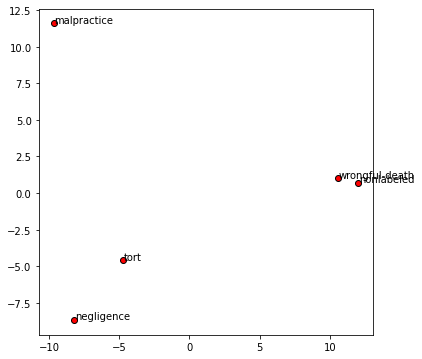

In [ ]:
display_pca_scatterplot(wv,False,['malpractice','tort','negligence','wrongful-death','nonlabeled'] )

In [ ]:
words = [ word for word in wv.vocab ]

In [ ]:
word_vectors = np.array([model[w] for w in words])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


importing relevant words from file

In [ ]:
import pickle
pickledwords=pickle.load(open('dictOfRelevantwords','rb'))

 Immigration Lawred
 Insurance Lawgreen
 Habeas Corpusblue
 Health Lawyellow
 Family Lawpink
 Contractsblack
 Administrative Laworange
 Attorney's Feespurple
 Sentencingbeige
 Environmental Lawbrown
 Injury &amp; Tort Lawgray
 Tax Lawcyan
 Bankruptcy Lawmagenta
225
638


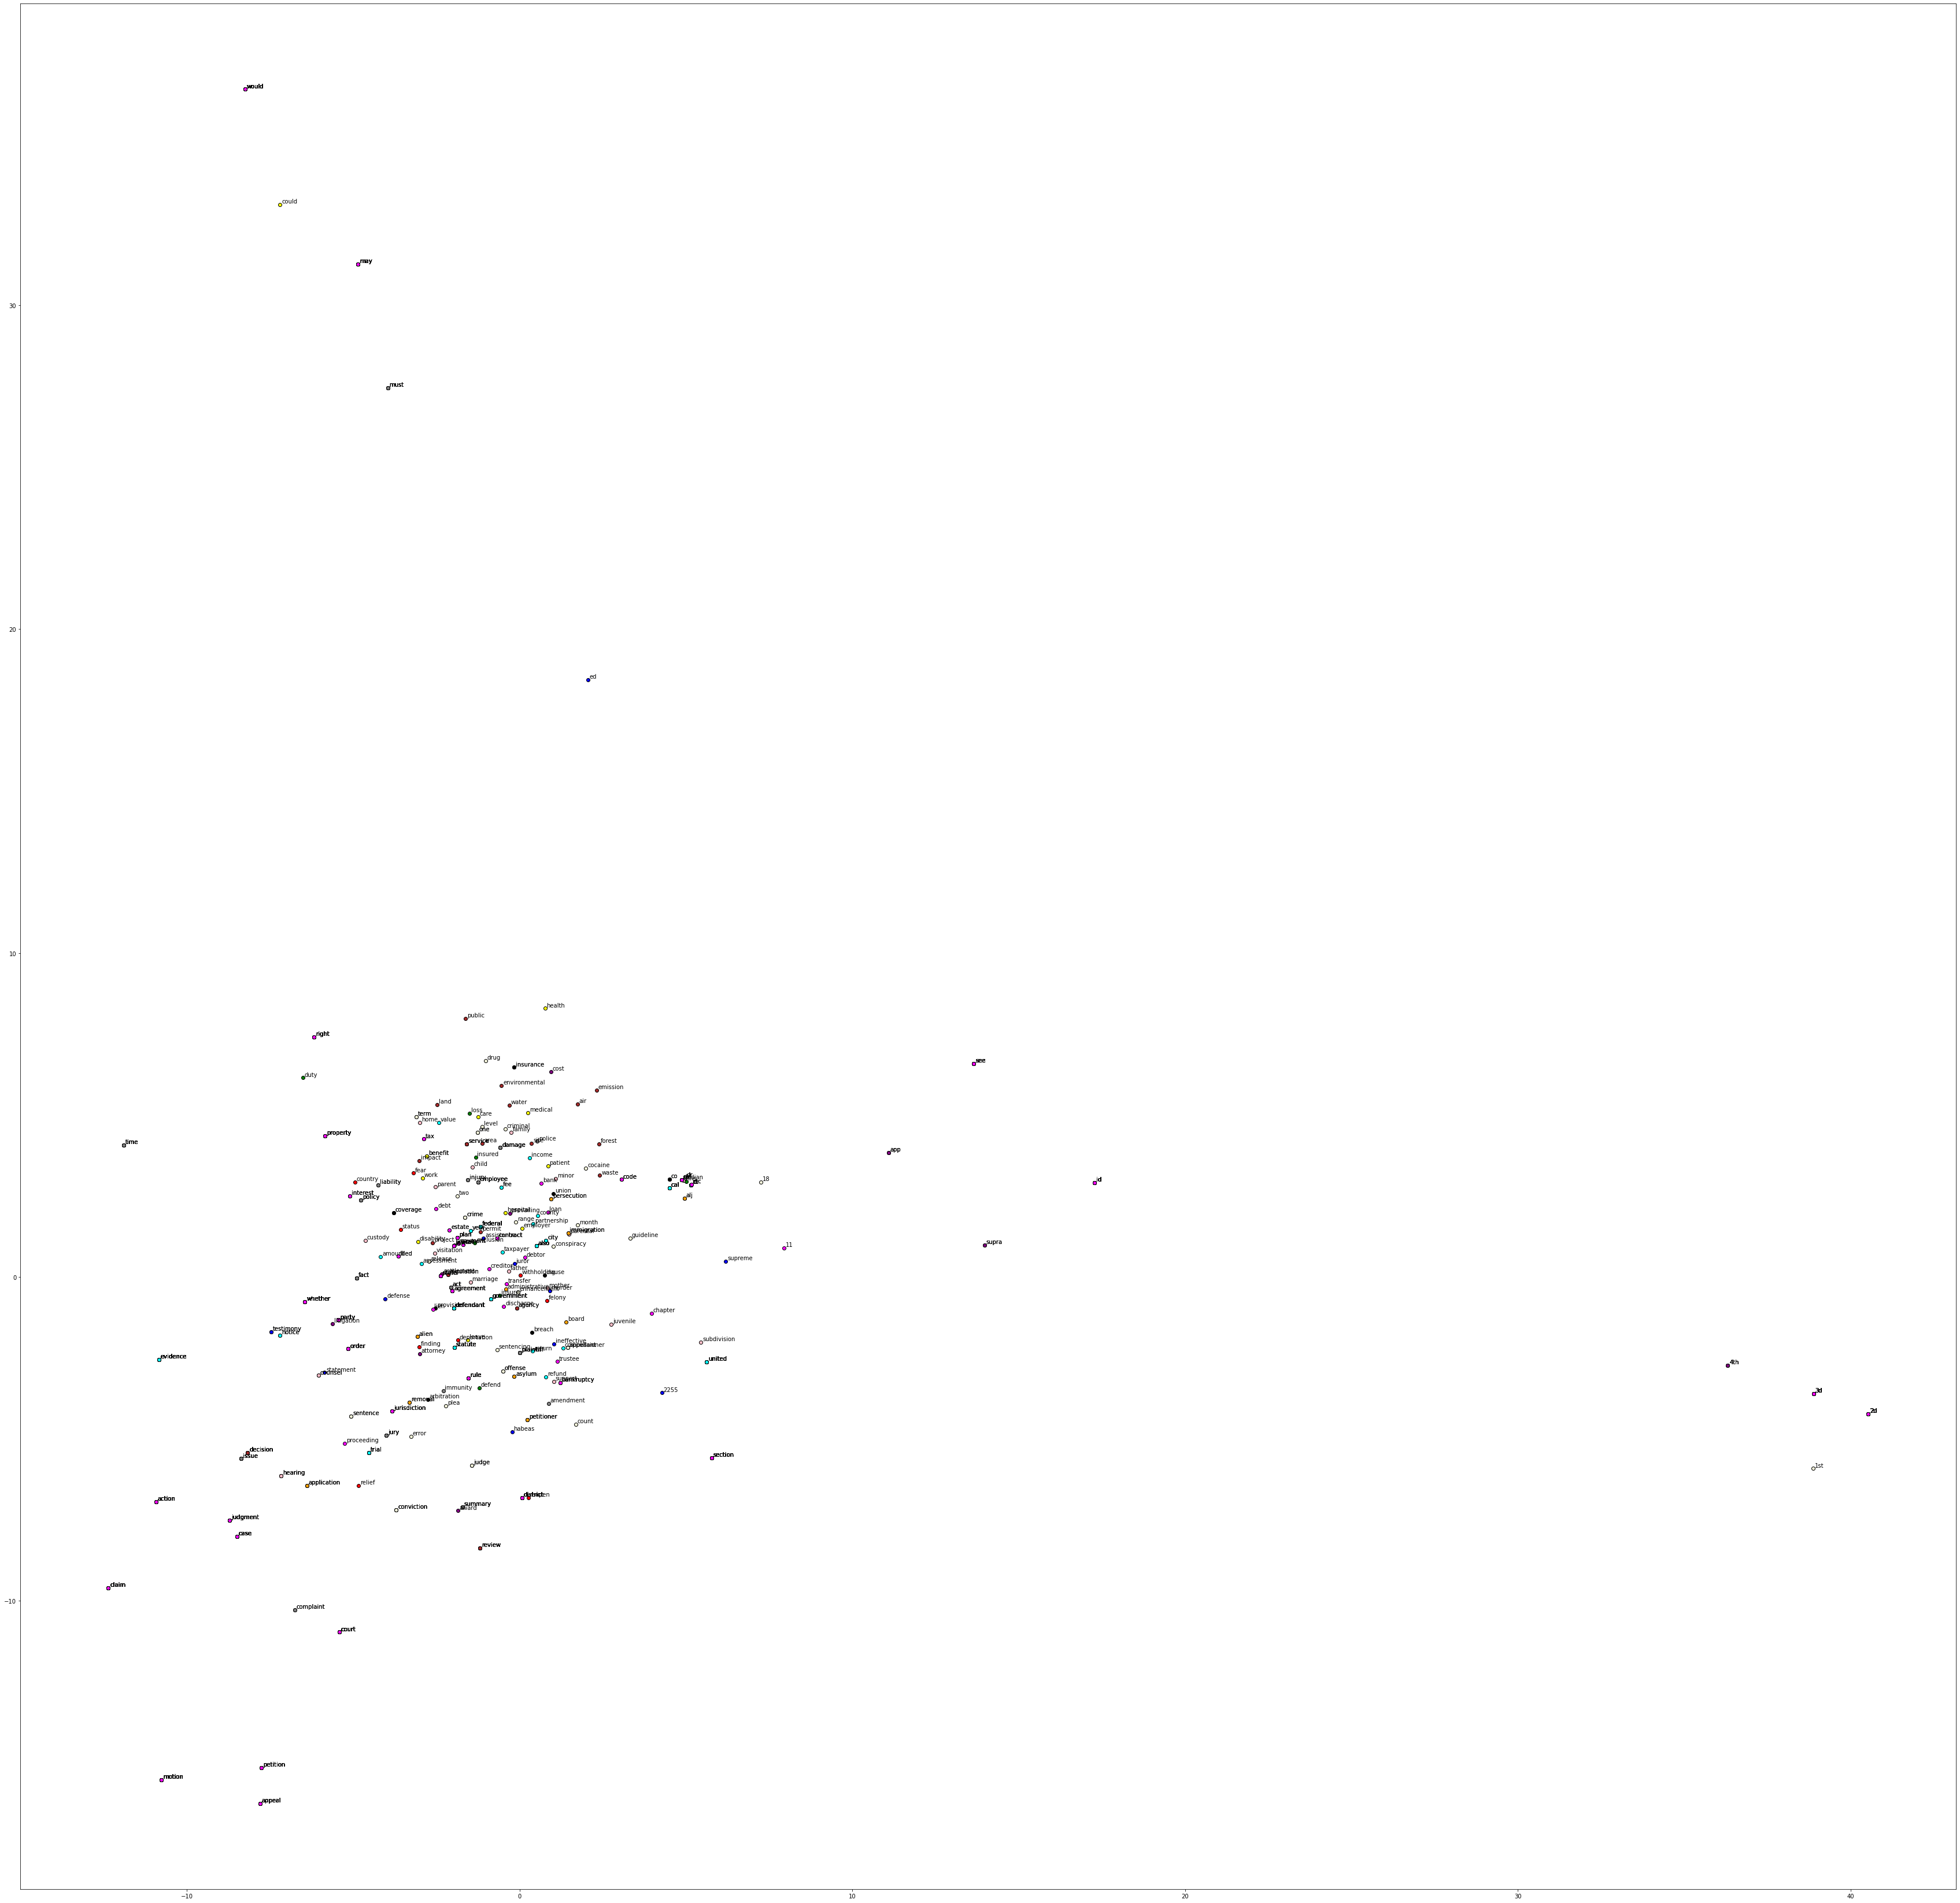

In [ ]:
display_pca_scatterplot(wv,True, pickledwords)

#Lime Code

In [ ]:
pip install lime

In [ ]:
limtrainx,limtestx,limtrainy,limtesty=train_test_split(data_frame20['case_text'], data_frame20['case_type'], test_size=0.20, random_state=1)

In [ ]:
xboost_ngram_lime=XGBClassifier()

In [ ]:
from sklearn import preprocessing
import sklearn
newset=preprocessing.LabelEncoder()
newset.fit(ngram_trainy)
ngram_trainy=newset.transform(ngram_trainy)
newset2=preprocessing.LabelEncoder()
newset2.fit(ngram_trainy)
ngram_testy=newset2.transform(ngram_testy)

LabelEncoder()

In [ ]:
ngram_trainy=newset.transform(ngram_trainy)

In [ ]:
ngram_testy=newset2.transform(ngram_testy)

In [ ]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(limtrainx)
test_vectors = vectorizer.transform(limtestx)

In [ ]:
xboost_ngram_lime.fit(train_vectors, ngram_trainy)

XGBClassifier(objective='multi:softprob')

In [ ]:
xboost_ngram_lime.predict(test_vectors)

array([ 0, 12,  1, ...,  1,  8,  9])

In [ ]:
pred=xboost_ngram_lime.predict(test_vectors)

In [ ]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, xboost_ngram_lime)

In [ ]:
import sklearn
sklearn.metrics.f1_score(ngram_testy, pred, average='weighted')

0.7207319550350113

In [ ]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=pd.unique(ngram_testy))

In [ ]:
class_names=list(pd.unique(ngram_testy))

In [ ]:
idx = 10
exp = explainer.explain_instance(limtestx.iloc[idx], c.predict_proba, num_features=8, labels=[0, 19])
print('Document id: %d' % idx)
print('Predicted class =', class_names[xboost_ngram_lime.predict(test_vectors[idx]).reshape(1,-1)[0,0]])
print('True class: %s' % class_names[ngram_testy[idx]])

Document id: 10
Predicted class = 8
True class: 8


In [ ]:
xboost_ngram_lime.predict(test_vectors[idx]).reshape(1,-1)[0,0]

17

In [ ]:
exp.as_list(label=0)

[('Board', 0.06812939386278383),
 ('1295', -0.0396876439876262),
 ('court', -0.025693285878580722),
 ('trial', -0.024880762160060684),
 ('defendant', -0.018500326037572373),
 ('plaintiff', -0.015314483544205941),
 ('decision', 0.013265049551026076),
 ('2006', 0.007860956270591421)]

In [ ]:
print ('Explanation for class %s' % class_names[0])
print ('\n'.join(map(str, exp.as_list(label=0))))
print ()
print ('Explanation for class %s' % class_names[13])
print ('\n'.join(map(str, exp.as_list(label=13))))

Explanation for class 0
('trial', -0.03675205905224632)
('administrative', 0.030330788373100364)
('damages', -0.029868684338336025)
('8th', -0.026804985615846173)
('environmental', -0.02453261032478025)
('court', -0.021314882926881672)
('agency', 0.020134232975384646)
('Environmental', -0.019344126730787756)

Explanation for class 19


KeyError: ignored

In [ ]:
exp = explainer.explain_instance(limtestx.iloc[idx], c.predict_proba, num_features=8, top_labels=4)
print(exp.available_labels())

[17, 8, 5, 13]


In [ ]:
exp.show_in_notebook(text=False)

In [ ]:
exp.show_in_notebook(text=limtestx.iloc[idx])